In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil
import random


In [2]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Set random seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()


Using: cuda


In [3]:
import os
import shutil
import random

def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    os.makedirs(output_dir, exist_ok=True)

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    species_list = os.listdir(source_dir)

    for species in tqdm(species_list, desc="Splitting data"):
        species_path = os.path.join(source_dir, species)
        if not os.path.isdir(species_path):
            continue

        files = [f for f in os.listdir(species_path) if f.endswith(('.ogg', '.wav'))]
        random.shuffle(files)

        n_total = len(files)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)

        splits = {
            'train': files[:n_train],
            'val': files[n_train:n_train + n_val],
            'test': files[n_train + n_val:]
        }

        for split_name, split_files in splits.items():
            split_species_dir = os.path.join(output_dir, split_name, species)
            os.makedirs(split_species_dir, exist_ok=True)

            for file in split_files:
                src = os.path.join(species_path, file)
                dst = os.path.join(split_species_dir, file)
                shutil.copy2(src, dst)

    print("✅ Dataset split into train/val/test folders.")

# Example usage:
split_dataset(
    source_dir="/kaggle/input/bird-dataset/dataset",
    output_dir="/kaggle/working/split",
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)


Splitting data: 100%|██████████| 53/53 [00:33<00:00,  1.58it/s]

✅ Dataset split into train/val/test folders.


In [4]:
import librosa
import numpy as np

def audio_to_mel(file_path, sr=48000, duration=3, n_fft=512, hop_length=128, n_mels=64, fmin=150, fmax=15000, target_width=384):
    y, _ = librosa.load(file_path, sr=sr)
    y = librosa.util.fix_length(y, size=sr * duration)  # Pad or crop to 3s

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                         hop_length=hop_length, n_mels=n_mels,
                                         fmin=fmin, fmax=fmax)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Pad or center-crop to width = 384
    if mel_db.shape[1] > target_width:
        mel_db = mel_db[:, :target_width]
    elif mel_db.shape[1] < target_width:
        mel_db = np.pad(mel_db, ((0, 0), (0, target_width - mel_db.shape[1])), mode='constant')

    return mel_db  # Final shape: [64, 384]


In [5]:
import os
import shutil

def generate_all_mels(input_dir, output_dir):
    for split in ['train', 'val', 'test']:
        print(f"🔁 Processing {split} data...")
        input_split_path = os.path.join(input_dir, split)
        output_split_path = os.path.join(output_dir, split)
        os.makedirs(output_split_path, exist_ok=True)

        for species in tqdm(os.listdir(input_split_path)):
            species_in = os.path.join(input_split_path, species)
            species_out = os.path.join(output_split_path, species)
            os.makedirs(species_out, exist_ok=True)

            for file in os.listdir(species_in):
                if not file.endswith(('.ogg', '.wav')):
                    continue

                src = os.path.join(species_in, file)
                dst = os.path.join(species_out, file.replace('.ogg', '.npy').replace('.wav', '.npy'))

                try:
                    mel = audio_to_mel(src)
                    np.save(dst, mel)
                except Exception as e:
                    print(f"⚠️ Error with {file}: {e}")

    print("✅ All mel spectrograms generated.")
    
generate_all_mels(
    input_dir="/kaggle/working/split",
    output_dir="/kaggle/working/mel-spectrograms"
)


🔁 Processing train data...


100%|██████████| 53/53 [01:49<00:00,  2.07s/it]


🔁 Processing val data...


100%|██████████| 53/53 [00:19<00:00,  2.68it/s]


🔁 Processing test data...


100%|██████████| 53/53 [00:21<00:00,  2.41it/s]

✅ All mel spectrograms generated.


In [6]:
species_list = sorted(os.listdir("/kaggle/working/mel-spectrograms/train"))
label_map = {species: idx for idx, species in enumerate(species_list)}
print("Total classes:", (label_map))  # should be 53


Total classes: {'41663': 0, '65448': 1, 'amakin1': 2, 'anhing': 3, 'babwar': 4, 'baymac': 5, 'bicwre1': 6, 'bkcdon': 7, 'blbwre1': 8, 'blcjay1': 9, 'brtpar1': 10, 'cargra1': 11, 'cattyr': 12, 'chfmac1': 13, 'cocwoo1': 14, 'colcha1': 15, 'crcwoo1': 16, 'eardov1': 17, 'gohman1': 18, 'grbhaw1': 19, 'greani1': 20, 'greibi1': 21, 'gretin1': 22, 'grnkin': 23, 'gybmar': 24, 'leagre': 25, 'mastit1': 26, 'neocor': 27, 'pavpig2': 28, 'plbwoo1': 29, 'purgal2': 30, 'ragmac1': 31, 'recwoo1': 32, 'rtlhum': 33, 'rufmot1': 34, 'rugdov': 35, 'ruther1': 36, 'secfly1': 37, 'snoegr': 38, 'speowl1': 39, 'srwswa1': 40, 'strowl1': 41, 'thbeup1': 42, 'thlsch3': 43, 'watjac1': 44, 'whbant1': 45, 'whbman1': 46, 'whfant1': 47, 'y00678': 48, 'yebsee1': 49, 'yecspi2': 50, 'yectyr1': 51, 'ywcpar': 52}


In [7]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os

class BirdSpectrogramDataset(Dataset):
    def __init__(self, root_dir, label_map):
        self.root_dir = root_dir
        self.samples = []
        self.label_map = label_map

        for species in os.listdir(root_dir):
            species_path = os.path.join(root_dir, species)
            if not os.path.isdir(species_path):
                continue

            for fname in os.listdir(species_path):
                if fname.endswith(".npy"):
                    label_idx = label_map[species]
                    self.samples.append((os.path.join(species_path, fname), label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        mel = np.load(file_path)  # shape: [64, 384]
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # → [1, 64, 384]
    
        # Instead of creating one-hot vector:
        # y = torch.zeros(len(self.label_map), dtype=torch.float32)
        # y[label] = 1.0
    
        y = torch.tensor(label, dtype=torch.long)  # single integer class index
    
        return mel, y



In [8]:
batch_size = 32

train_dataset = BirdSpectrogramDataset("/kaggle/working/mel-spectrograms/train", label_map)
val_dataset   = BirdSpectrogramDataset("/kaggle/working/mel-spectrograms/val", label_map)
test_dataset  = BirdSpectrogramDataset("/kaggle/working/mel-spectrograms/test", label_map)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)
print("done")

done


In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + identity)

class LogMeanExpPool(nn.Module):
    def __init__(self, sharpness=5.0):
        super().__init__()
        self.sharpness = sharpness

    def forward(self, x):
        # x shape: [B, C, H, W]
        x = x.view(x.size(0), x.size(1), -1)  # flatten H*W
        return (1 / self.sharpness) * torch.logsumexp(self.sharpness * x, dim=2)

class BirdNETModel(nn.Module):
    def __init__(self, num_classes=53):
        super().__init__()

        self.preprocess = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2))  # [1, 64, 384] → [32, 64, 192]
        )

        self.stack = nn.Sequential(
            ResidualBlock(32, 64, downsample=True),   # [64, 32, 96]
            ResidualBlock(64, 128, downsample=True),  # [128, 16, 48]
            ResidualBlock(128, 256, downsample=True), # [256, 8, 24]
            ResidualBlock(256, 512, downsample=True), # [512, 4, 12]
        )

        self.pool = LogMeanExpPool()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):  # x: [B, 1, 64, 384]
        x = self.preprocess(x)
        x = self.stack(x)
        x = self.pool(x)          # → [B, 512]
        x = self.dropout(x)
        return self.classifier(x)  # raw logits for CrossEntropyLoss
# nn.CrossEntropyLoss in PyTorch expects raw logits as input because it internally applies LogSoftmax + NLLLoss for numerical stability 




In [10]:
model = BirdNETModel(num_classes=len(label_map)).to(device)


In [11]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, classification_report

def train_model(model, train_loader, val_loader,
                epochs=20, lr=1e-3, patience=3,
                save_path="best_birdnet.pth", label_map=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        # ----- TRAIN -----
        model.train()
        total_loss = 0.0
        correct = 0
        samples = 0

        for X, y in tqdm(train_loader, desc=f"Epoch {epoch} – Training"):
            X, y = X.to(device), y.squeeze().to(device).long()

            optimizer.zero_grad()
            outputs = model(X)  # [B, C]: raw logits
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            samples += y.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / samples

        # ----- VALIDATION -----
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.squeeze().to(device).long()
                outputs = model(X)
                val_loss += criterion(outputs, y).item() * X.size(0)

                preds = outputs.argmax(dim=1)
                all_preds.append(preds.cpu())
                all_labels.append(y.cpu())

        avg_val_loss = val_loss / len(val_loader.dataset)
        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()

        val_acc = accuracy_score(all_labels, all_preds)
        val_f1_macro = f1_score(all_labels, all_preds, average='macro')
        val_f1_micro = f1_score(all_labels, all_preds, average='micro')  # equals accuracy in multi-class :contentReference[oaicite:1]{index=1}

        scheduler.step(avg_val_loss)

        # ----- LOGGING -----
        print(f"\n📊 Epoch {epoch} — "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc*100:.2f}%, "
              f"Macro-F1: {val_f1_macro:.4f}, Micro-F1: {val_f1_micro:.4f}")

        if label_map is not None:
            print("\n📋 Classification Report:")
            print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

        # ----- SAVE & EARLY STOPPING -----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model (epoch {epoch})")
        else:
            patience_counter += 1
            print(f"⚠️ Early stop counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("🛑 Early stopping triggered.")
                break

    print(f"\n🎯 Training complete. Best model saved to: {save_path}")


In [12]:
train_model(model, train_loader, val_loader, epochs=20,save_path="best_birdnet.pth", lr=1e-3, patience=3)


Epoch 1 – Training: 100%|██████████| 90/90 [00:09<00:00,  9.55it/s]



📊 Epoch 1 — Train Loss: 4.8878, Acc: 2.58% | Val Loss: 3.9656, Acc: 4.04%, Macro-F1: 0.0103, Micro-F1: 0.0404
✅ Saved best model (epoch 1)


Epoch 2 – Training: 100%|██████████| 90/90 [00:06<00:00, 14.90it/s]



📊 Epoch 2 — Train Loss: 4.2456, Acc: 3.17% | Val Loss: 3.9360, Acc: 4.55%, Macro-F1: 0.0180, Micro-F1: 0.0455
✅ Saved best model (epoch 2)


Epoch 3 – Training: 100%|██████████| 90/90 [00:06<00:00, 14.89it/s]



📊 Epoch 3 — Train Loss: 4.1041, Acc: 4.50% | Val Loss: 3.8389, Acc: 5.22%, Macro-F1: 0.0126, Micro-F1: 0.0522
✅ Saved best model (epoch 3)


Epoch 4 – Training: 100%|██████████| 90/90 [00:06<00:00, 14.68it/s]



📊 Epoch 4 — Train Loss: 4.0063, Acc: 6.00% | Val Loss: 3.8096, Acc: 4.38%, Macro-F1: 0.0235, Micro-F1: 0.0438
✅ Saved best model (epoch 4)


Epoch 5 – Training: 100%|██████████| 90/90 [00:06<00:00, 14.43it/s]



📊 Epoch 5 — Train Loss: 3.8887, Acc: 7.56% | Val Loss: 3.7574, Acc: 8.08%, Macro-F1: 0.0558, Micro-F1: 0.0808
✅ Saved best model (epoch 5)


Epoch 6 – Training: 100%|██████████| 90/90 [00:06<00:00, 14.24it/s]



📊 Epoch 6 — Train Loss: 3.8079, Acc: 9.31% | Val Loss: 3.6628, Acc: 8.42%, Macro-F1: 0.0598, Micro-F1: 0.0842
✅ Saved best model (epoch 6)


Epoch 7 – Training: 100%|██████████| 90/90 [00:06<00:00, 14.04it/s]



📊 Epoch 7 — Train Loss: 3.6753, Acc: 11.54% | Val Loss: 3.7491, Acc: 8.25%, Macro-F1: 0.0619, Micro-F1: 0.0825
⚠️ Early stop counter: 1/3


Epoch 8 – Training: 100%|██████████| 90/90 [00:06<00:00, 13.79it/s]



📊 Epoch 8 — Train Loss: 3.5969, Acc: 13.07% | Val Loss: 3.5563, Acc: 12.12%, Macro-F1: 0.0987, Micro-F1: 0.1212
✅ Saved best model (epoch 8)


Epoch 9 – Training: 100%|██████████| 90/90 [00:06<00:00, 13.57it/s]



📊 Epoch 9 — Train Loss: 3.4902, Acc: 14.95% | Val Loss: 3.5220, Acc: 11.95%, Macro-F1: 0.0877, Micro-F1: 0.1195
✅ Saved best model (epoch 9)


Epoch 10 – Training: 100%|██████████| 90/90 [00:06<00:00, 13.27it/s]



📊 Epoch 10 — Train Loss: 3.3738, Acc: 17.53% | Val Loss: 3.5423, Acc: 12.63%, Macro-F1: 0.1055, Micro-F1: 0.1263
⚠️ Early stop counter: 1/3


Epoch 11 – Training: 100%|██████████| 90/90 [00:07<00:00, 12.74it/s]



📊 Epoch 11 — Train Loss: 3.2615, Acc: 19.14% | Val Loss: 3.5329, Acc: 13.13%, Macro-F1: 0.1255, Micro-F1: 0.1313
⚠️ Early stop counter: 2/3


Epoch 12 – Training: 100%|██████████| 90/90 [00:07<00:00, 12.42it/s]



📊 Epoch 12 — Train Loss: 3.1279, Acc: 22.06% | Val Loss: 3.4309, Acc: 17.34%, Macro-F1: 0.1592, Micro-F1: 0.1734
✅ Saved best model (epoch 12)


Epoch 13 – Training: 100%|██████████| 90/90 [00:07<00:00, 12.40it/s]



📊 Epoch 13 — Train Loss: 3.0563, Acc: 23.74% | Val Loss: 3.4938, Acc: 17.34%, Macro-F1: 0.1660, Micro-F1: 0.1734
⚠️ Early stop counter: 1/3


Epoch 14 – Training: 100%|██████████| 90/90 [00:07<00:00, 12.40it/s]



📊 Epoch 14 — Train Loss: 2.9412, Acc: 26.59% | Val Loss: 3.5380, Acc: 15.82%, Macro-F1: 0.1406, Micro-F1: 0.1582
⚠️ Early stop counter: 2/3


Epoch 15 – Training: 100%|██████████| 90/90 [00:06<00:00, 12.86it/s]



📊 Epoch 15 — Train Loss: 2.7971, Acc: 28.69% | Val Loss: 3.6495, Acc: 16.67%, Macro-F1: 0.1303, Micro-F1: 0.1667
⚠️ Early stop counter: 3/3
🛑 Early stopping triggered.

🎯 Training complete. Best model saved to: best_birdnet.pth


In [15]:

    def evaluate_model(model, data_loader, label_map):
        device = next(model.parameters()).device
        model.eval()
    
        correct = total = 0
    
        with torch.no_grad():
            for X, y in tqdm(data_loader, desc="Evaluating"):
                X, y = X.to(device), y.to(device).long()
                outputs = model(X)              # raw logits [B, C]
                preds = outputs.argmax(dim=1)   # [B]: predicted class indices
    
                correct += (preds == y).sum().item()
                total += y.size(0)
    
        accuracy = correct / total
        print(f"\n🎯 Test Accuracy: {accuracy * 100:.2f}%")
    


In [16]:
# Recreate model and load best weights
model = BirdNETModel(num_classes=len(label_map))
model.load_state_dict(torch.load("best_birdnet.pth"))

# Evaluate on test set
evaluate_model(model, test_loader, label_map)


Evaluating: 100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


🎯 Test Accuracy: 15.87%


In [17]:
def visualize_predictions(model, data_loader, label_map, n=5):
    model.eval()
    device = next(model.parameters()).device
    inv_map = {v: k for k, v in label_map.items()}
    shown = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device).long()
            outputs = model(X)
            preds = outputs.argmax(dim=1)  # integer predictions

            for i in range(X.size(0)):
                if shown >= n:
                    return

                mel = X[i].cpu().squeeze(0)
                true_label = inv_map[y[i].item()]
                pred_label = inv_map[preds[i].item()]

                print(f"\nExample {shown + 1}")
                print(f"Logits: {outputs[i].cpu().numpy()}")
                print(f"True: {true_label}")
                print(f"Pred: {pred_label}")

                plt.figure(figsize=(10, 3))
                plt.imshow(mel, aspect='auto', origin='lower', cmap='magma')
                plt.title(f"True: {true_label}   Pred: {pred_label}")
                plt.colorbar()
                plt.show()

                shown += 1



Example 1
Logits: [-0.7990457  -4.367732   -1.9205184  -0.42047787 -1.2579949  -2.8637068
 -1.1781828  -1.6605835  -2.802001   -4.079712   -3.2398372  -0.6823293
 -1.453832   -1.5737736  -1.8001673  -2.870842   -2.851911   -2.3968873
 -2.4329958  -2.7243145  -3.018256   -3.0849416  -1.9742999  -2.1568499
 -0.29103792 -0.3851779  -1.7953415  -0.58963627 -1.465565   -0.81177586
 -1.5317985  -2.4111102  -2.8429163  -2.2928698  -2.8826706  -1.7994576
 -0.8138063  -1.9961435  -0.8788871  -1.3936517  -1.2314669  -0.08976653
 -2.4551742  -2.9313588  -1.3116844  -1.198495   -1.5609202  -3.4353118
 -0.98368144 -2.0014777  -0.42091125 -3.2380223  -1.7210312 ]
True: neocor
Pred: strowl1


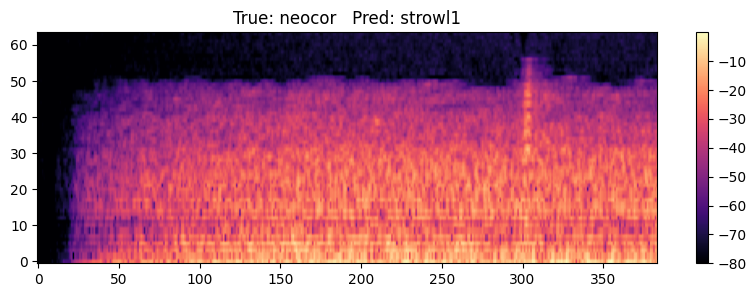


Example 2
Logits: [-1.0785398  -5.4845934  -2.1187143  -0.49333015 -0.36407664 -3.0551715
 -1.9932978  -2.46859    -2.857132   -2.9424577  -3.7467484  -1.1276975
 -1.1608862  -1.5091443  -1.9877771  -2.1267781  -2.8430486  -1.5601265
 -2.345889   -1.7338895  -2.795191   -3.2827985  -3.6616328  -1.9741447
 -0.92259    -0.8436422  -1.4542744  -1.0478187  -1.6028948  -1.0880423
 -1.6321454  -1.7211899  -2.724311   -1.235206   -4.0157185  -1.5399954
 -1.9692264  -1.1821134  -0.3816138  -2.4434717  -0.99796957 -0.04579055
 -2.0942814  -2.2684455  -2.2818382  -1.5221448  -1.0288707  -0.12754464
  0.5359779  -1.2113509  -2.0787435  -2.996549   -3.3311186 ]
True: neocor
Pred: y00678


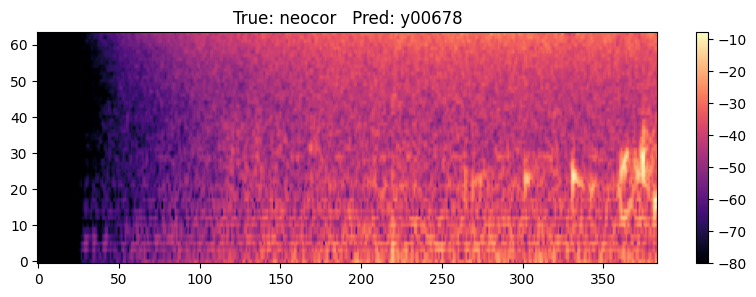


Example 3
Logits: [ 0.22319138 -3.8261223  -2.0335279   0.37282884 -0.261213   -1.6681563
 -0.9670817  -2.2728937  -2.7272906  -4.017227   -3.1195195  -0.52452123
 -1.9382603  -1.230392   -2.5296845  -2.325463   -2.4810245  -1.7975085
 -3.5065808  -2.7156138  -2.4258296  -2.460177   -2.6088674  -2.7919402
  0.05476463 -1.0070348  -2.3615537   0.39662468 -2.665556   -1.5974709
 -0.8535074  -2.300857   -3.130051   -3.1560597  -3.4378781  -1.7873919
 -0.07689287 -2.580152   -0.32598162 -1.4214096  -2.0693479   0.03163984
 -2.5865936  -3.1360435  -1.0296044  -1.2735696  -2.1335201  -3.227037
  0.27542222 -2.5416212  -1.3858306  -4.5835533  -1.7894673 ]
True: neocor
Pred: neocor


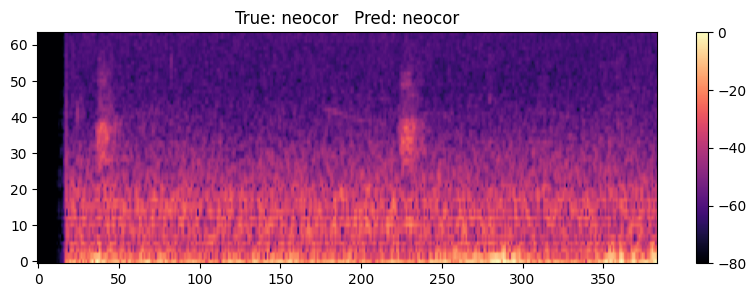


Example 4
Logits: [-0.49776435 -4.893358   -1.5264261  -0.05008526 -0.07425764 -2.3274965
 -0.9261646  -2.321114   -3.1114972  -4.366127   -2.7260106  -0.45744354
 -1.2711495  -1.0273433  -2.2019696  -2.9321604  -2.818091   -1.493981
 -3.1677876  -2.450488   -2.3988023  -2.4603188  -2.9764366  -1.8023213
 -0.02502213 -0.7225131  -1.9824979   0.18108943 -1.4981043  -1.1866896
 -1.0425458  -2.3066726  -3.0313053  -2.5813975  -3.6620893  -1.4296042
 -0.15137401 -2.328405   -1.141583   -1.58588    -1.15328    -0.18356636
 -3.0307813  -3.108674   -1.3053067  -1.4818804  -0.8967555  -2.4324768
 -0.05222381 -1.8490547  -0.6253401  -3.525332   -2.1499147 ]
True: neocor
Pred: neocor


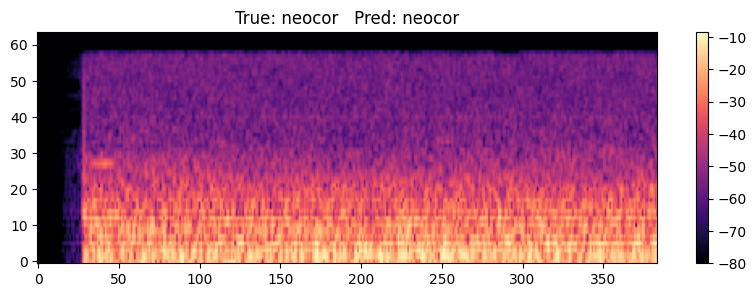


Example 5
Logits: [-0.25714085 -6.010211   -2.834224   -0.38431197 -2.0587034  -3.552472
 -1.8610833  -1.5790145  -3.7341483  -3.690955   -3.7496488  -0.66855544
 -1.0221403  -1.9079511  -0.650187   -3.4484205  -3.7344522  -3.2324996
 -2.2217398  -1.5536187  -3.8641748  -4.2870493  -4.1487803  -2.8629818
 -1.0015017  -0.30236736 -1.7287056  -0.7933957  -1.9538242  -0.59059846
 -2.1673     -2.6838765  -3.0093954  -2.991832   -4.824999   -2.7210119
 -1.5035863  -1.367152   -2.8014777  -3.743938   -1.6754208  -0.9133028
 -3.1066864  -2.91993    -1.7816842  -2.0285497  -1.4213095  -0.13714325
 -1.2120426  -1.6747146  -2.0617163  -2.7858086  -0.5026444 ]
True: neocor
Pred: whfant1


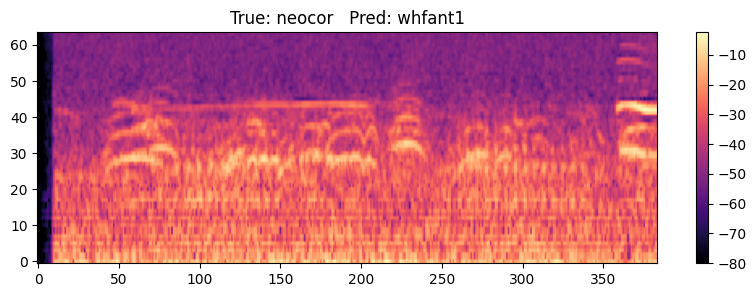

In [19]:
visualize_predictions(model, test_loader, label_map, n=5)